In [1]:
import numpy as np
from numpy.typing import NDArray

In [2]:
n_equations, n_dim = 4, 4
np.diag(np.ones(4))

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [3]:
import numpy as np

def sinusoid_vector(t: float) -> np.ndarray:
    """
    Returns a vector of different sinusoidal function outputs for a given time t.

    Parameters
    ----------
    t : float
        The time input (can be integer or float).

    Returns
    -------
    np.ndarray
        A vector (1D array) of sinusoidal values with different frequencies, amplitudes, and phases.
    """
    # Define different sinusoidal components
    # y1 = np.sin(0.1 * np.pi * 0.1 * t)       # 1 Hz sine
    y1 = 3. - np.sin(0.01 * np.pi * 0.2 * t + np.pi / 4)  # 2 Hz sine with phase shift
    y2 = np.sin(0.1 * np.pi * 0.2 * t + np.pi / 4)  # 2 Hz sine with phase shift
    y3 = 0.5 * np.sin(0.2 * np.pi * 0.3 * t) # 3 Hz sine with smaller amplitude
    y4 = np.cos(0.1 * np.pi * 0.5 * t)     # Cosine with different frequency

    y5 = np.sin(0.01 * np.pi * 0.1 * t)       # 1 Hz sine
    y6 = 3. - np.sin(0.01 * np.pi * 0.2 * t + np.pi / 4)  # 2 Hz sine with phase shift
    y7 = 0.5 * np.sin(0.9 * np.pi * 0.3 * t) # 3 Hz sine with smaller amplitude
    y8 = 1. + np.cos(0.1 * np.pi * 0.1 * t)     # Cosine with different frequency

    # Combine into a vector
    return np.array([y1, y2, y3, y4, y5, y6, y7, y8])


In [4]:
def relu(x: NDArray[np.float64]) -> NDArray[np.float64]:
  """
  Activation for z
  """
  x[x < 0.] = 0.
  return x

def ground_truth_function(x: NDArray[np.float64]) -> NDArray[np.float64]:
  """
  Ground truth which we want to model.
  We obtain this from the multiparameter model of the OUA paper.
  """
  # return np.sin(5 * x)
  theta_star = np.diag(np.ones(x.shape[0]))
  return np.tanh(theta_star @ x)



class HyperNet:

  """
  Neural network parameterized as a system of
  Stochastic differential equations solved via
  Energy-based Langevin Dynamics
  """

  def __init__(self, n_dim: int, n_equations: int):
    self.n_dim = n_dim
    self.n_equations = n_equations
    self.z = np.random.rand(n_equations, n_dim)
    self.theta = np.random.rand(n_equations, n_dim)
    self.diffusion_matrix = np.diag(np.random.choice(np.random.rand(1000), n_dim))
    self.mu = np.random.rand(n_equations, n_dim)
    # self.r_ma = np.zeros(n_equations) # Moving Average Reward
    self.r_ma = 0.
    self.timestep = 1e-4 # Default
    self.alpha = 1e-1 #Observation noise size
    self.rho = 1. # Time constant to solve ODE for Moving Average Reward
    self.lambda_ = 1e-4 # Step size for neuron parameter updates, also 1 / variance of Gaussian


  def get_noise(self) -> NDArray[np.float64]:
    """
    Generate noise for stochastic differential equation
    """
    return np.random.normal(0, 1, size=(self.n_equations, self.n_dim))

  def update(
      self,
      x_i: NDArray[np.float64],
      mu: NDArray[np.float64],
      sigma: NDArray[np.float64]
    ) -> float:
    """
    Update rule for Euler-Maruyama integration
    """
    return  x_i + mu * x_i * self.timestep + sigma * x_i * self.get_noise()

  def get_reward(self, y_true: NDArray[np.float64], y_pred: NDArray[np.float64]) -> float:
    """
    Return MSE used in energy-based calculations
    Use Hadamard product to get vector of outputs
    """
    error = y_pred - y_true
    return np.mean(error * error)

  def forward(self, x: NDArray[np.float64]) -> NDArray[np.float64]:

    logits = self.theta @ x

    # Activation function plus process noise
    self.z += relu(logits) * self.timestep + self.get_noise()

    # Activation function for prediction plus observation noise
    y_pred = np.tanh(logits) + self.alpha * self.get_noise()
    y_true = ground_truth_function(x)

    r = self.get_reward(y_true, y_pred)

    # Update the Reward Prediction Error (RPE)
    reward_prediction_error = (r - self.r_ma)
    self.r_ma += self.rho * reward_prediction_error

    # Update parameter average
    self.mu += self.timestep * reward_prediction_error * (self.theta - self.mu)

    # Update actual parameters for SDE
    noise = self.get_noise()

    # Treat matrix multiplication as operating on several column vectors at once
    wiener_process = self.diffusion_matrix @ noise.T

    # Euler-Maruyama update rule for SDE
    self.theta += self.lambda_ * (self.mu - self.theta) * self.timestep + np.sqrt(self.timestep) * wiener_process

    return y_pred

In [5]:
net = HyperNet(n_dim=8, n_equations=8)

In [6]:
net.theta.shape, net.lambda_, net.mu.shape

((8, 8), 0.0001, (8, 8))

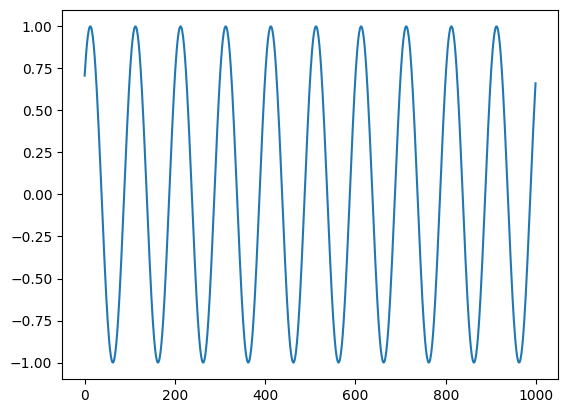

In [15]:
import matplotlib.pyplot as plt

t = np.linspace(0, 999999, 1000000)
# t = 0.1
x = sinusoid_vector(t)
x.shape
plt.plot(t[:1000], x[1][:1000])

1.0


In [17]:
# Training loop
reward_history = []
data = x.T

for i in range(len(t)):
  net.forward(data[i])
  reward_history.append(net.r_ma)
  print(f"Training Step {i} completed.")

Streaming output truncated to the last 5000 lines.
Training Step 995000 completed.
Training Step 995001 completed.
Training Step 995002 completed.
Training Step 995003 completed.
Training Step 995004 completed.
Training Step 995005 completed.
Training Step 995006 completed.
Training Step 995007 completed.
Training Step 995008 completed.
Training Step 995009 completed.
Training Step 995010 completed.
Training Step 995011 completed.
Training Step 995012 completed.
Training Step 995013 completed.
Training Step 995014 completed.
Training Step 995015 completed.
Training Step 995016 completed.
Training Step 995017 completed.
Training Step 995018 completed.
Training Step 995019 completed.
Training Step 995020 completed.
Training Step 995021 completed.
Training Step 995022 completed.
Training Step 995023 completed.
Training Step 995024 completed.
Training Step 995025 completed.
Training Step 995026 completed.
Training Step 995027 completed.
Training Step 995028 completed.
Training Step 995029 

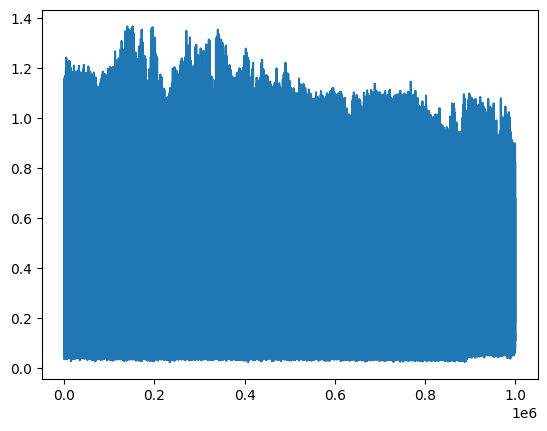

In [18]:
plt.plot(reward_history)

In [19]:
pred = net.forward(data[0])
pred.shape, data[-1].shape, data.shape

((8, 8), (8,), (1000000, 8))

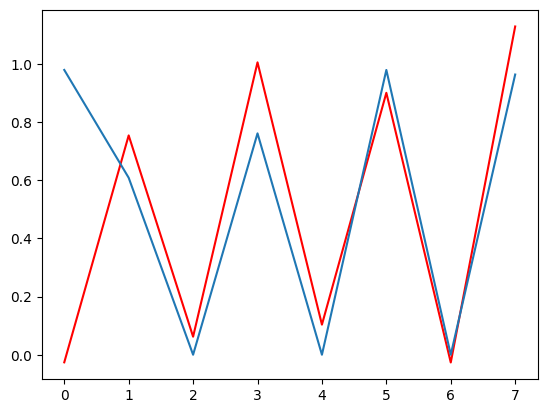

In [20]:
plt.plot(pred[0], 'red')
plt.plot(ground_truth_function(data[0]))

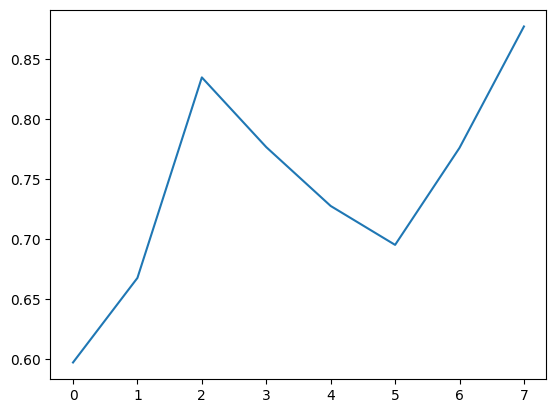

In [ ]:
plt.plot(pred.T[-1])

In [ ]:
pred = net.forward(data[1])
pred.shape, data[1].shape, data.shape

((8, 8), (8,), (1000000, 8))

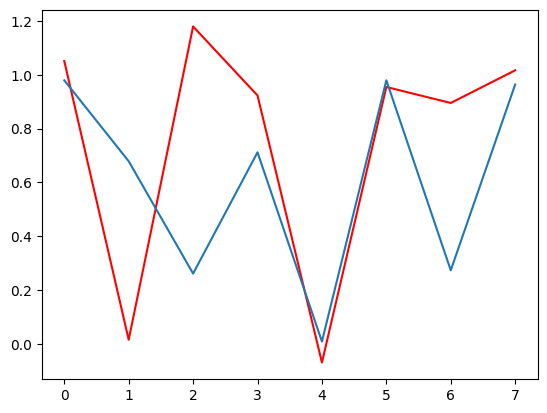

In [ ]:
index = 3
plt.plot(pred[index], 'red')
plt.plot(ground_truth_function(data[index]))

In [ ]:
W = np.random.rand(3, 2)
# x = np.random.rand(2)
x = np.random.normal(0, 1, size=(2,))

print(W @ x, x)

[-0.45323168 -0.21698757 -0.19130132] [-0.42349007 -0.27668889]


In [ ]:
relu(x)

array([0., 0.])

In [ ]:
np.diag(np.random.choice(np.random.rand(1000),4))

array([[0.55441751, 0.        , 0.        , 0.        ],
       [0.        , 0.90505713, 0.        , 0.        ],
       [0.        , 0.        , 0.27433895, 0.        ],
       [0.        , 0.        , 0.        , 0.2230739 ]])

In [ ]:
np.random.rand(10)

array([0.33886582, 0.43233645, 0.16693316, 0.94581359, 0.72331768,
       0.61983292, 0.93832378, 0.55561774, 0.91835775, 0.31389185])

In [ ]:
np.random.normal(0, 1, size=(3, 2))

array([[-0.6145453 , -1.11177557],
       [-1.18409473,  0.42692994],
       [ 0.26167052, -0.70825158]])

In [ ]:
W = np.random.rand(3, 2)
A = np.random.rand(3, 2)


In [ ]:
W

array([[0.36316929, 0.1519261 ],
       [0.60470184, 0.91546417],
       [0.95300858, 0.36594059]])

In [ ]:
A

array([[0.64337135, 0.80347044],
       [0.96479504, 0.82447959],
       [0.00240305, 0.13667345]])

In [ ]:
np.transpose(A)

array([[0.64337135, 0.96479504, 0.00240305],
       [0.80347044, 0.82447959, 0.13667345]])

In [ ]:
A.T

array([[0.64337135, 0.96479504, 0.00240305],
       [0.80347044, 0.82447959, 0.13667345]])

## Updated with Numerical Libraries

In [ ]:
! pip install diffrax equinox jax
import jax
import jax.numpy as jnp
import jax.random as jr
from diffrax import diffeqsolve, ControlTerm, EulerHeun, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree
import diffrax as dfx
import equinox as eqx
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.transforms import ScaledTranslation
import numpy as np
import pandas as pd
from diffrax import UnsafeBrownianPath

# Initial setup
media = ''
qcmap = sns.color_palette('colorblind')
alpha_level = 0.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.2/193.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 8.5 MB/s eta 0:00:00


In [ ]:
# Activation functions
def relu(x):
    """ReLU activation: max(0, x)."""
    return jnp.maximum(0, x)

def sigmoid(x):
    """Sigmoid activation: 1 / (1 + exp(-x))."""
    return 1 / (1 + jnp.exp(-x))

def tanh(x):
    """Hyperbolic tangent activation."""
    return jnp.tanh(x)

def logit(y):
    """Inverse sigmoid (logit) function."""
    if y <= 0 or y >= 1:
        raise ValueError("Input must be in the range (0, 1), exclusive.")
    return jnp.log(y / (1 - y))

In [ ]:
# Data processing utilities
def zca_whitening(X):
    """
    Perform ZCA whitening on a dataset using JAX.

    Args:
        X: Input dataset of shape (T, N), where T is samples, N is features.

    Returns:
        Whitened dataset, whitening matrix, and mean.
    """
    # Center the data
    X_mean = jnp.mean(X, axis=0)
    X_centered = X - X_mean

    # Compute covariance and eigendecomposition
    cov_matrix = jnp.cov(X_centered, rowvar=False)
    eigenvalues, eigenvectors = jnp.linalg.eigh(cov_matrix)

    # Form whitening matrix with regularization
    epsilon = 1e-5
    D = jnp.diag(1.0 / jnp.sqrt(eigenvalues + epsilon))
    whitening_matrix = eigenvectors @ D @ eigenvectors.T

    # Apply whitening
    X_zca = X_centered @ whitening_matrix

    return X_zca, whitening_matrix, X_mean

def generate_weather_data(delay_pred=24, split_indx=90000, decorrelation=False, path=''):
    """
    Generate synthetic hourly weather data mimicking Szeged, Hungary (2006-2016).

    Generates plausible time series for temperature, humidity, wind speed,
    wind bearing, and pressure using sinusoidal patterns and noise.

    Handles outliers in pressure, decorrelates via ZCA if requested, normalizes,
    and prepares inputs/labels for temperature prediction.

    Args:
        delay_pred: Prediction horizon in hours.
        split_indx: Train-test split index.
        decorrelation: Whether to apply ZCA whitening.
        path: Ignored (for compatibility with original loading function).

    Returns:
        Train/test splits, feature names, mean, std.
    """
    # Generate synthetic data
    T = 100000  # Approximate number of hourly samples (~11.4 years)
    t = np.arange(T, dtype='float32')

    # Temperature: annual + daily cycles + noise
    temp = 15 + 10 * np.sin(2 * np.pi * t / (365 * 24)) + 5 * np.sin(2 * np.pi * t / 24) + np.random.normal(0, 2, T)

    # Humidity: inversely related to temperature + noise (clipped 0.01-0.99)
    humidity = 0.7 - 0.3 * (temp - 15) / 15 + np.random.normal(0, 0.1, T)
    humidity = np.clip(humidity, 0.01, 0.99)

    # Wind speed: gamma distributed (positive, skewed)
    wind_speed = np.random.gamma(2, 2, T)  # Mean ~4 km/h

    # Wind bearing: uniform 0-360 degrees
    wind_bearing = np.random.uniform(0, 360, T)

    # Pressure: normal around 1013 mb
    pressure = 1013 + np.random.normal(0, 5, T)

    data = np.column_stack([temp, humidity, wind_speed, wind_bearing, pressure]).astype('float32')

    # Encode wind bearing as sine/cosine
    data = np.hstack([
        data[:, :3],
        np.sin(2 * np.pi * data[:, 3] / 360)[:, np.newaxis],
        np.cos(2 * np.pi * data[:, 3] / 360)[:, np.newaxis],
        data[:, -1][:, np.newaxis]
    ])
    features_names = [
        'Temperature (C)', 'Relative humidity', 'Wind speed (km/h)',
        'Sine wind bearing', 'Cosine wind bearing', 'Pressure (millibars)'
    ]

    # Handle pressure outliers (though unlikely in synthetic data)
    data[data[:, -1] == 0.0, -1] = jnp.nan
    df = pd.DataFrame(data)
    data = jnp.array(df.interpolate(method='linear', axis=0, limit_direction='both').to_numpy())

    # Optional ZCA decorrelation
    if decorrelation:
        data, W_zca, X_mean = zca_whitening(data)

    # Normalize
    data_mean = jnp.nanmean(data, axis=0)
    data -= data_mean
    data_std = jnp.nanstd(data, axis=0)
    data /= data_std

    # Prepare features and labels (predict temperature)
    features = data[:-delay_pred]
    labels = data[delay_pred:, 0]

    # Train-test split
    x_train = features[:split_indx]
    y_train = labels[:split_indx]
    x_test = features[split_indx:]
    y_test = labels[split_indx:]

    return (x_train, y_train), (x_test, y_test), features_names, data_mean, data_std

In [ ]:
# Core diffusive learning algorithm (updated for matrix parameters)
def diffusive_learning(
    control_fun,          # Input function: t -> vector of shape (d_in,)
    reward_fun,           # Reward: (input_vec, theta_flat, t) -> scalar
    target_fun,      # Optional target output: t -> vector of shape (d_out,)
    y0,                   # Initial state: [rbar0, theta_flat0, mu_flat0, gain0]
    theta_shape,          # Shape of theta matrix: (d_out, d_in)
    dt=0.05,
    t0=0.0,
    t1=200.0,
    epsilon=1.0,          # Adaptation rate for reward average
    lambd=1.0,            # Mean reversion rate for theta
    sigma=0.5,            # Noise scale for theta
    eta=1.0,              # Adaptation rate for mu
    key=jr.PRNGKey(0)
):
    """
    Simulate diffusive learning via SDE for matrix-parameter models.

    The state evolves as:
    - dr_bar = ε (r - r_bar) dt
    - dθ = λ (μ - θ) dt + σ dW  (θ, μ flattened)
    - dμ = η (r - r_bar) (θ - μ) dt
    - dg = r dt  (cumulative gain)

    Reward r is scalar, computed from linear transformation y = θ @ x(t),
    aggregating contributions across output dimensions.

    Args:
        control_fun: Function returning input vector x(t).
        reward_fun: Scalar reward based on prediction error.
        target_fun: Optional target vector y^*(t).
        y0: Initial state vector.
        theta_shape: Tuple (d_out, d_in) for reshaping flattened theta.
        ... (other hyperparameters)

    Returns:
        Time steps and state trajectories.
    """
    d_out, d_in = theta_shape
    M = d_out * d_in  # Total parameters (flattened)

    assert y0.shape[0] == 2 * M + 2, f"State size mismatch: expected {2*M+2}, got {y0.shape[0]}"

    @eqx.filter_jit
    def drift_fun(t, y, args):
        """Drift term for the SDE."""
        rbar = y[0]
        theta_flat = y[1:1 + M]
        mu_flat = y[1 + M:1 + 2 * M]
        gain = y[-1]

        # Get input and optional target
        x_t = args[0](t)  # shape (d_in,)
        if len(args) > 1 and args[1] is not None:
            target_t = args[1](t)  # shape (d_out,)
        else:
            target_t = None

        # Compute scalar reward (aggregates over output components)
        r = reward_fun(x_t, theta_flat, t, target_t, theta_shape)

        # Reshape for vectorized operations
        theta = jnp.reshape(theta_flat, theta_shape)
        mu = jnp.reshape(mu_flat, theta_shape)

        # Drift components
        dr_bar = epsilon * (r - rbar)
        dtheta_flat = lambd * (mu_flat - theta_flat)
        dmu_flat = eta * (r - rbar) * (theta_flat - mu_flat)
        dg = r

        return jnp.hstack([dr_bar, dtheta_flat, dmu_flat, dg])

    # Wiener process for noise on theta (flattened)
    brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(M,), key=key)

    # Diffusion: noise only on theta
    def diffusion_fun(t, y, args):
        D = jnp.vstack([
            jnp.zeros((1, M)),
            sigma * jnp.eye(M),
            jnp.zeros((M, M)),
            jnp.zeros((1, M))
        ]).T  # Shape (state_dim, M)
        return D

    noise_term = ControlTerm(diffusion_fun, brownian_motion)
    ode_term = ODETerm(drift_fun)
    terms = MultiTerm(ode_term, noise_term)

    # Solve SDE
    solver = EulerHeun()
    saveat = SaveAt(steps=True)
    if target_fun is None:
        sol = diffeqsolve(
            terms, solver, t0, t1, dt0=dt, y0=y0, saveat=saveat, args=[control_fun],
            max_steps=100000
        )
    else:
        sol = diffeqsolve(
            terms, solver, t0, t1, dt0=dt, y0=y0, saveat=saveat, args=[control_fun, target_fun],
            max_steps=300000
        )

    # Filter infinite values
    mask = ~jnp.isinf(sol.ts)
    ts = sol.ts[mask]
    ys = sol.ys[mask, :]

    return ts, ys

In [ ]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Learning a matrix-parameter model (2D output, 6D input from weather data)
def example_reward_fun(x_t, theta_flat, t, target_t, theta_shape):
    """
    Example scalar reward: negative MSE aggregated over output components.

    Aggregates contributions: r = -sum_i (pred_i - target_i)^2

    Args:
        x_t: Input vector (d_in=6,).
        theta_flat: Flattened parameters (d_out * d_in,).
        t: Time.
        target_t: Target vector (d_out=2,); if None, use ground-truth linear model.
        theta_shape: (d_out=2, d_in=6).

    Returns:
        Scalar reward.
    """
    d_out, d_in = theta_shape
    print(f"DEBUG: x_t shape: {x_t.shape}, theta_flat shape: {theta_flat.shape}, theta_shape: {theta_shape}")
    theta_mat = jnp.reshape(theta_flat, (d_out, d_in))

    # Prediction: linear transformation
    pred = theta_mat @ x_t  # shape (d_out=2,)
    print(f"DEBUG: pred shape: {pred.shape}")

    # Target: ground-truth matrix @ x_t
    if target_t is None:
        # Example 2x6 ground-truth matrix for weather features
        theta_gt = jnp.array([
            [1.0, 0.2, 0.1, 0.0, 0.0, 0.05],  # Weights for temperature output
            [0.5, 0.1, 0.05, 0.0, 0.0, 0.02]  # Weights for secondary output
        ])
        target_t = theta_gt @ x_t
    print(f"DEBUG: target_t shape: {target_t.shape}")

    # Scalar reward: aggregate MSE over components
    mse = jnp.sum((pred - target_t) ** 2)
    return -mse  # Negative for reward maximization

# Example vector input function using synthetic weather data
def vector_control_fun(t):
    """Vector-valued input from synthetic weather data at time t."""
    # Simulate accessing weather data at time index (discretized)
    t_idx = jnp.clip(jnp.floor(t * 24).astype(jnp.int32), 0, 99999)  # Scale t to hours
    (x_train, _), _, _, _, _ = generate_weather_data()
    x_t = x_train[t_idx]  # shape (6,)
    print(f"DEBUG: vector_control_fun t={t}, t_idx={t_idx}, x_t shape: {x_t.shape}")
    return x_t

# Optional vector target function
def vector_target_fun(t):
    """Ground-truth output vector for two target variables."""
    return jnp.array([jnp.sin(0.1 * t), 0.5 * jnp.cos(0.05 * t)])  # shape (2,)

# Setup for 2x6 matrix (d_out=2, d_in=6, M=12)
d_out, d_in = 2, 6  # 6 input features from weather data
M = d_out * d_in  # M = 12
theta0_flat = jnp.zeros(2 * M + 2)
mu0_flat = theta0_flat.copy()
rbar0 = 0.0
gain0 = 0.0
y0 = jnp.hstack([rbar0, theta0_flat, mu0_flat, gain0])
print(f"DEBUG: y0 shape: {y0.shape}, expected: {2 * M + 2}")

# Run single simulation
key = jr.PRNGKey(0)
ts, ys = diffusive_learning(
    vector_control_fun, example_reward_fun, vector_target_fun, y0,
    theta_shape=(d_out, d_in), t0=0, t1=300, key=key
)

# Extract trajectories
rbars = ys[:, 0]
theta_flats = ys[:, 1:1 + M]
mus_flats = ys[:, 1 + M:1 + 2 * M]
gains = ys[:, -1]

# Reshape for plotting (select a few theta components for visualization)
theta_mats = jnp.reshape(theta_flats, (ts.shape[0], d_out, d_in))
theta11 = theta_mats[:, 0, 0]  # theta[0,0] (e.g., temp weight for temp output)
theta21 = theta_mats[:, 1, 0]  # theta[1,0] (e.g., temp weight for secondary output)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Rewards and average
rewards = jax.vmap(lambda t, th: example_reward_fun(
    vector_control_fun(t), th, t, vector_target_fun(t), (d_out, d_in)
))(ts, theta_flats)
axes[0, 0].plot(ts, rewards, label='Instantaneous reward', alpha=0.7)
axes[0, 0].plot(ts, rbars, label=r'$\bar{r}$', linewidth=2)
axes[0, 0].set_ylabel('Reward')
axes[0, 0].legend()
axes[0, 0].set_title('(a) Rewards')

# Theta components (example: temperature weights)
axes[0, 1].plot(ts, theta11, label=r'$\theta_{11}$ (Temp weight)', linewidth=2)
axes[0, 1].plot(ts, theta21, label=r'$\theta_{21}$ (Temp weight)', linewidth=2)
axes[0, 1].axhline(y=1.0, color='r', linestyle='--', label='Target $\theta_{11}$')
axes[0, 1].axhline(y=0.5, color='g', linestyle='--', label='Target $\theta_{21}$')
axes[0, 1].set_ylabel(r'$\theta$ components')
axes[0, 1].set_xlabel('Time [s]')
axes[0, 1].legend()
axes[0, 1].set_title('(b) Learned Parameters')

# Mu components (similar)
mu_mats = jnp.reshape(mus_flats, (ts.shape[0], d_out, d_in))
mu11 = mu_mats[:, 0, 0]
mu21 = mu_mats[:, 1, 0]
axes[1, 0].plot(ts, mu11, label=r'$\mu_{11}$', linewidth=2)
axes[1, 0].plot(ts, mu21, label=r'$\mu_{21}$', linewidth=2)
axes[1, 0].set_ylabel(r'$\mu$ components')
axes[1, 0].set_xlabel('Time [s]')
axes[1, 0].legend()
axes[1, 0].set_title('(c) Adapted Means')

# Cumulative gain
axes[1, 1].plot(ts, gains, label='With learning', linewidth=2)
# Baseline: no learning
y0_base = y0.copy()
ts_base, ys_base = diffusive_learning(
    vector_control_fun, example_reward_fun, vector_target_fun, y0_base,
    theta_shape=(d_out, d_in), t0=0, t1=300,
    epsilon=0.0, lambd=0.0, sigma=0.0, eta=0.0, key=key
)
axes[1, 1].plot(ts_base, ys_base[:, -1], label='No learning', linewidth=2)
axes[1, 1].set_ylabel('Cumulative Gain $G$')
axes[1, 1].set_xlabel('Time [s]')
axes[1, 1].legend()
axes[1, 1].set_title('(d) Performance')

plt.tight_layout()
plt.show()

# Batched parallel simulations for multiple runs
N_runs = 15
keys = jr.split(jr.PRNGKey(42), N_runs)  # Different seed for variety
ts_batch, ys_batch = jax.vmap(
    lambda k: diffusive_learning(
        vector_control_fun, example_reward_fun, vector_target_fun, y0,
        theta_shape=(d_out, d_in), t0=0, t1=300, key=k
    )
)(keys)

# Extract batched trajectories
ts = ts_batch[0]
rbars_batch = ys_batch[:, :, 0].T  # (N_runs, len(ts))
theta_flats_batch = ys_batch[:, :, 1:1 + M].T  # (N_runs, len(ts), M)
gains_batch = ys_batch[:, :, -1].T

# Reshape theta batch for component-wise plotting
theta_mats_batch = jnp.reshape(theta_flats_batch, (N_runs, ts.shape[0], d_out, d_in))
theta11_batch = theta_mats_batch[:, :, 0, 0]  # (N_runs, len(ts))

# Multi-run plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Theta evolution across runs
for i in range(N_runs):
    axes[0, 0].plot(ts, theta11_batch[i], color='gray', alpha=0.6, linewidth=1)
axes[0, 0].plot(ts, jnp.mean(theta11_batch, axis=0), color='blue', linewidth=3, label='Mean')
axes[0, 0].axhline(y=1.0, color='red', linestyle='--', label='Target')
axes[0, 0].set_xlabel('Time [s]')
axes[0, 0].set_ylabel(r'$\theta_{11}$ (Temp weight)')
axes[0, 0].legend()
axes[0, 0].text(0.05, 0.95, '(a)', transform=axes[0, 0].transAxes, va='top')

# Reward averages
mean_rbar = jnp.mean(rbars_batch, axis=0)
std_rbar = jnp.std(rbars_batch, axis=0)
axes[0, 1].plot(ts, mean_rbar, linewidth=2)
axes[0, 1].fill_between(ts, mean_rbar - std_rbar, mean_rbar + std_rbar, alpha=0.3)
axes[0, 1].set_xlabel('Time [s]')
axes[0, 1].set_ylabel(r'Mean $\bar{r}$ $\pm$ std')
axes[0, 1].text(0.05, 0.95, '(b)', transform=axes[0, 1].transAxes, va='top')

# Cumulative gains
mean_gain = jnp.mean(gains_batch, axis=0)
std_gain = jnp.std(gains_batch, axis=0)
axes[1, 0].plot(ts, mean_gain, linewidth=2, label='With learning')
axes[1, 0].fill_between(ts, mean_gain - std_gain, mean_gain + std_gain, alpha=0.3)

# Baseline batch (no learning)
y0_base_batch = jnp.tile(y0_base[None, :], (N_runs, 1))
ts_base_batch, ys_base_batch = jax.vmap(
    lambda k: diffusive_learning(
        vector_control_fun, example_reward_fun, vector_target_fun, y0_base,
        theta_shape=(d_out, d_in), t0=0, t1=300,
        epsilon=0.0, lambd=0.0, sigma=0.0, eta=0.0, key=k
    )
)(keys)
gains_base_batch = ys_base_batch[:, :, -1].T
mean_gain_base = jnp.mean(gains_base_batch, axis=0)
std_gain_base = jnp.std(gains_base_batch, axis=0)
axes[1, 0].plot(ts, mean_gain_base, linewidth=2, label='No learning')
axes[1, 0].fill_between(ts, mean_gain_base - std_gain_base, mean_gain_base + std_gain_base, alpha=0.3)
axes[1, 0].set_xlabel('Time [s]')
axes[1, 0].set_ylabel('Mean Gain $G$ $\pm$ std')
axes[1, 0].legend()
axes[1, 0].text(0.05, 0.95, '(c)', transform=axes[1, 0].transAxes, va='top')

# Distribution of final thetas
final_thetas = theta11_batch[:, -1]
axes[1, 1].hist(final_thetas, bins=20, density=True, alpha=0.7, color='skyblue')
axes[1, 1].axhline(y=1.0, color='red', linestyle='--', label='Target')
axes[1, 1].set_xlabel(r'Final $\theta_{11}$ (Temp weight)')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend()
axes[1, 1].text(0.05, 0.95, '(d)', transform=axes[1, 1].transAxes, va='top')

plt.tight_layout()
plt.show()

DEBUG: y0 shape: (54,), expected: 26


<>:204: SyntaxWarning: invalid escape sequence '\p'
<>:204: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-1052248222.py:204: SyntaxWarning: invalid escape sequence '\p'
  axes[1, 0].set_ylabel('Mean Gain $G$ $\pm$ std')


AssertionError: State size mismatch: expected 26, got 54